<a href="https://colab.research.google.com/github/Bright-Momo/SimplifiedJournalsGame/blob/main/effect_of_continuous_%CE%BB_and_%CE%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

# Parameters
alpha = 0.6
r = 1.0
c = 0.5
gamma = 0.1

def acceptance_probability(is_good_paper, journal_strategy, epsilon, lam):
    if journal_strategy == 0:  # Always Accept
        return 1.0
    elif journal_strategy == 1:  # Only Accept Good
        return 1 - epsilon if is_good_paper else lam
    elif journal_strategy == 2:  # Only Accept Bad
        return epsilon if is_good_paper else 1 - lam
    else:  # Reject All
        return 0.0

def author_journal_payoff(author_strategy, journal_strategy, epsilon, lam):
    if author_strategy == 0:
        good_prob, bad_prob = alpha, 1 - alpha
    elif author_strategy == 1:
        good_prob, bad_prob = alpha, 0
    elif author_strategy == 2:
        good_prob, bad_prob = 0, 1 - alpha
    else:
        good_prob, bad_prob = 0, 0

    p_accept_good = acceptance_probability(True, journal_strategy, epsilon, lam)
    p_accept_bad = acceptance_probability(False, journal_strategy, epsilon, lam)

    accept_rate = good_prob * p_accept_good + bad_prob * p_accept_bad
    submit_rate = good_prob + bad_prob
    reject_rate = submit_rate - accept_rate

    author_payoff = accept_rate * r - reject_rate * c

    # Payoff equation
    if accept_rate > 0:
        journal_payoff = (good_prob * p_accept_good) / accept_rate - gamma * submit_rate
    else:
        journal_payoff = 0  # pay nothing if no receive paper

    return author_payoff, journal_payoff

def build_payoff_matrices(epsilon, lam):
    num_strategies = 4

    # Initialize payoff matrices
    author_payoff_matrix = np.zeros((num_strategies, num_strategies))
    journal_payoff_matrix = np.zeros((num_strategies, num_strategies))

    # Calculate payoffs for all strategy combinations
    for i in range(num_strategies):
        for j in range(num_strategies):
            author_pay, journal_pay = author_journal_payoff(i, j, epsilon, lam)
            author_payoff_matrix[i, j] = author_pay
            journal_payoff_matrix[i, j] = journal_pay

    return author_payoff_matrix, journal_payoff_matrix



In [ ]:
def replicator_dynamics(y, t, author_matrix, journal_matrix):
    # Strategy frequencies
    author_freqs = y[:4]
    journal_freqs = y[4:]

    # Frequencies are valid
    author_freqs = np.clip(author_freqs, 0, 1)
    journal_freqs = np.clip(journal_freqs, 0, 1)

    # Sum equals 1
    author_freqs = author_freqs / np.sum(author_freqs)
    journal_freqs = journal_freqs / np.sum(journal_freqs)

    # Expected payoffs for each strategy
    author_expected_payoffs = np.dot(author_matrix, journal_freqs)
    journal_expected_payoffs = np.dot(author_freqs, journal_matrix)

    # Average payoffs
    avg_author_payoff = np.dot(author_freqs, author_expected_payoffs)
    avg_journal_payoff = np.dot(journal_freqs, journal_expected_payoffs)

    # Replicator equation
    author_derivs = author_freqs * (author_expected_payoffs - avg_author_payoff)
    journal_derivs = journal_freqs * (journal_expected_payoffs - avg_journal_payoff)

    # Combine derivatives and return
    return np.concatenate([author_derivs, journal_derivs])

def simulate_dynamics_for_parameters(epsilon, lam):
    author_matrix, journal_matrix = build_payoff_matrices(epsilon, lam)

    # Initial conditions: equal distribution among strategies
    initial_freqs = np.ones(8) / 4.0
    t = np.arange(0, 1000.1, 0.1)  # t=1000 with step=0.1

    solution = odeint(replicator_dynamics, initial_freqs, t, args=(author_matrix, journal_matrix))

    # Final state
    final_state = solution[-1, :]
    author_final = final_state[:4]
    journal_final = final_state[4:]

    # Normalize to ensure they sum to 1
    author_final = author_final / np.sum(author_final)
    journal_final = journal_final / np.sum(journal_final)

    # Clip any negative values (due to numerical issues)
    author_final = np.clip(author_final, 0, 1)
    journal_final = np.clip(journal_final, 0, 1)

    # Find dominant strategies
    dominant_author = np.argmax(author_final)
    dominant_journal = np.argmax(journal_final)

    return author_final, journal_final, dominant_author, dominant_journal

# Generate a continuous grid of error rates
num_points = 21  # 21x21 grid for smooth visualization
epsilon_values = np.linspace(0, 1, num_points)
lambda_values = np.linspace(0, 1, num_points)

# Initialize result arrays
author_results = np.zeros((num_points, num_points, 4))  # 4 strategies
journal_results = np.zeros((num_points, num_points, 4))  # 4 strategies
dominant_author = np.zeros((num_points, num_points), dtype=int)
dominant_journal = np.zeros((num_points, num_points), dtype=int)

# Run simulations for all parameter combinations
for i, epsilon in enumerate(epsilon_values):
    print(f"Processing epsilon or lambda = {epsilon:.2f}")
    for j, lam in enumerate(lambda_values):
        author_final, journal_final, dom_author, dom_journal = simulate_dynamics_for_parameters(epsilon, lam)
        author_results[i, j, :] = author_final
        journal_results[i, j, :] = journal_final
        dominant_author[i, j] = dom_author
        dominant_journal[i, j] = dom_journal



Processing epsilon or lambda = 0.00
Processing epsilon or lambda = 0.05
Processing epsilon or lambda = 0.10
Processing epsilon or lambda = 0.15
Processing epsilon or lambda = 0.20
Processing epsilon or lambda = 0.25
Processing epsilon or lambda = 0.30
Processing epsilon or lambda = 0.35
Processing epsilon or lambda = 0.40
Processing epsilon or lambda = 0.45
Processing epsilon or lambda = 0.50
Processing epsilon or lambda = 0.55
Processing epsilon or lambda = 0.60
Processing epsilon or lambda = 0.65
Processing epsilon or lambda = 0.70
Processing epsilon or lambda = 0.75
Processing epsilon or lambda = 0.80
Processing epsilon or lambda = 0.85
Processing epsilon or lambda = 0.90
Processing epsilon or lambda = 0.95
Processing epsilon or lambda = 1.00


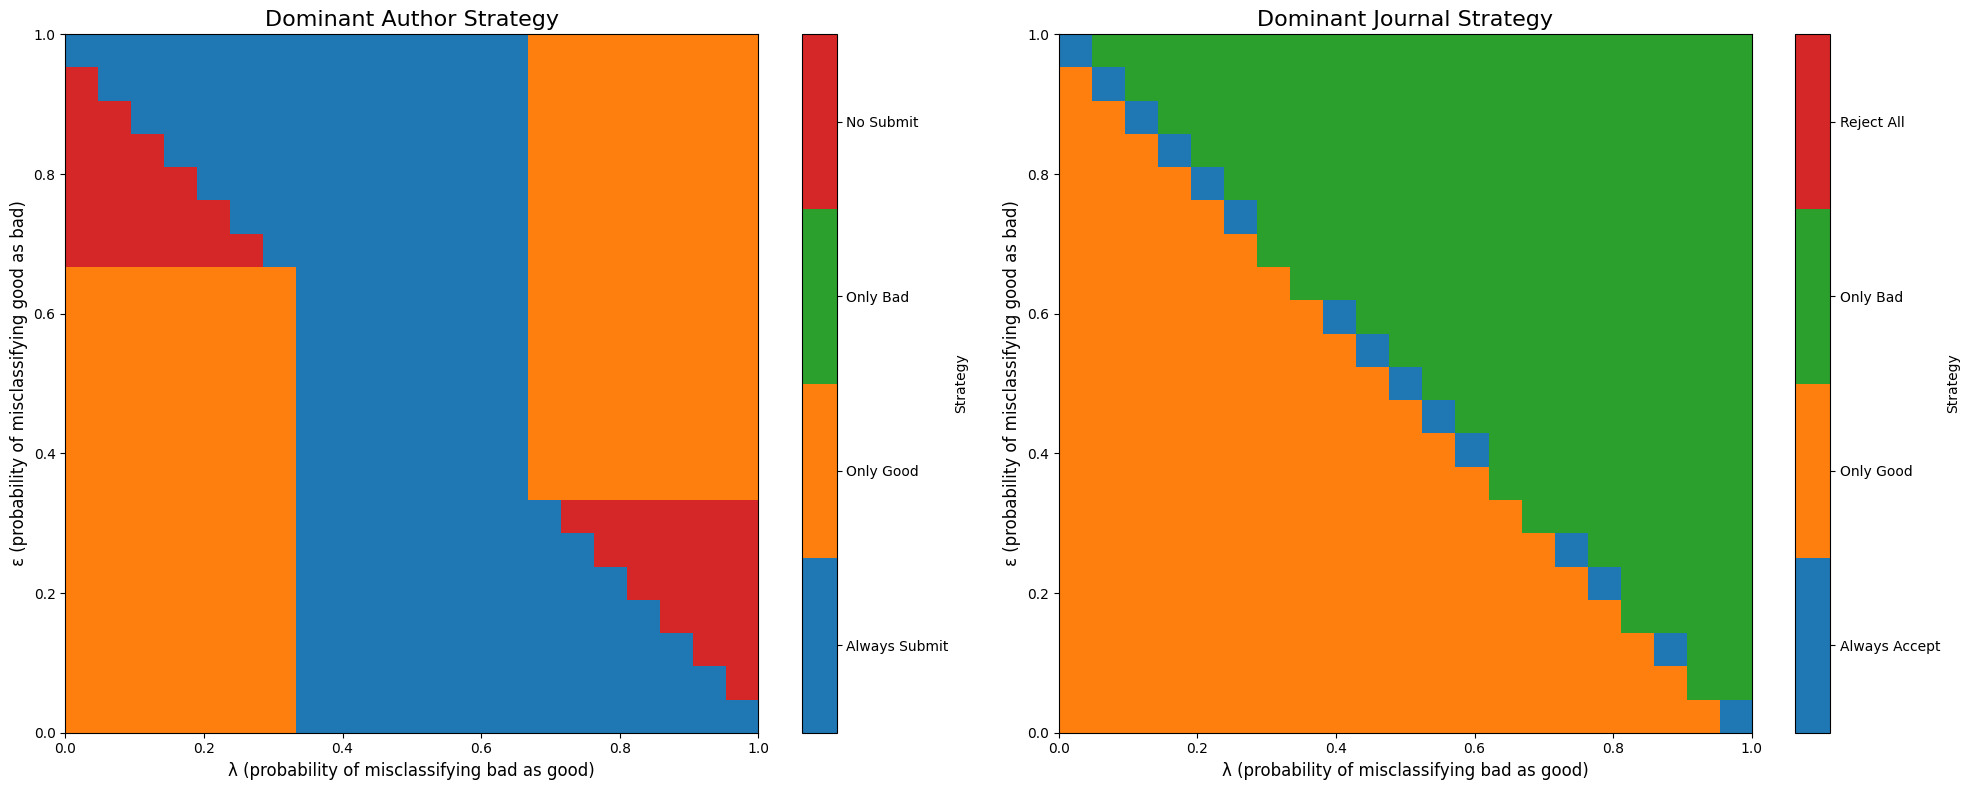

In [ ]:
# Strategy names for visualization
author_names = ["Always Submit", "Only Good", "Only Bad", "No Submit"]
journal_names = ["Always Accept", "Only Good", "Only Bad", "Reject All"]

# Create a custom colormap
colors = plt.cm.tab10(np.linspace(0, 1, 10))
strategy_cmap = LinearSegmentedColormap.from_list("strategies", colors[:4], N=4)

# Create visualization of dominant strategies
plt.figure(figsize=(20, 8))

# Plot dominant author strategies
plt.subplot(1, 2, 1)
plt.imshow(dominant_author, cmap=strategy_cmap, origin='lower', extent=[0, 1, 0, 1], aspect='auto')
plt.colorbar(ticks=[0, 1, 2, 3], label="Strategy")
plt.clim(-0.5, 3.5)
plt.title("Dominant Author Strategy", fontsize=16)
plt.xlabel("λ (probability of misclassifying bad as good)", fontsize=12)
plt.ylabel("ε (probability of misclassifying good as bad)", fontsize=12)

# Add strategy labels to the colorbar
plt.gca().figure.axes[-1].set_yticklabels(author_names)

# Plot dominant journal strategies
plt.subplot(1, 2, 2)
plt.imshow(dominant_journal, cmap=strategy_cmap, origin='lower', extent=[0, 1, 0, 1], aspect='auto')
plt.colorbar(ticks=[0, 1, 2, 3], label="Strategy")
plt.clim(-0.5, 3.5)
plt.title("Dominant Journal Strategy", fontsize=16)
plt.xlabel("λ (probability of misclassifying bad as good)", fontsize=12)
plt.ylabel("ε (probability of misclassifying good as bad)", fontsize=12)

# Add strategy labels to the colorbar
plt.gca().figure.axes[-1].set_yticklabels(journal_names)

plt.tight_layout()
plt.savefig("dominant_strategies_continuous.png", dpi=300, bbox_inches='tight')




Summary of Findings:
1. Dominant author strategies across error space:
   - Always Submit: 46.0% of parameter space
   - Only Good: 44.4% of parameter space
   - Only Bad: 0.0% of parameter space
   - No Submit: 9.5% of parameter space

2. Dominant journal strategies across error space:
   - Always Accept: 3.4% of parameter space
   - Only Good: 47.6% of parameter space
   - Only Bad: 49.0% of parameter space
   - Reject All: 0.0% of parameter space

3. Key transition points:
   - Author strategy transition at ε=0.00, λ=0.30
   - Author strategy transition at ε=0.05, λ=0.30
   - Author strategy transition at ε=0.10, λ=0.30
   - Author strategy transition at ε=0.15, λ=0.30
   - Author strategy transition at ε=0.20, λ=0.30
   - Author strategy transition at ε=0.25, λ=0.30
   - Author strategy transition at ε=0.30, λ=0.30
   - Author strategy transition at ε=0.35, λ=0.30
   - Author strategy transition at ε=0.40, λ=0.30
   - Author strategy transition at ε=0.45, λ=0.30
   - Author strate

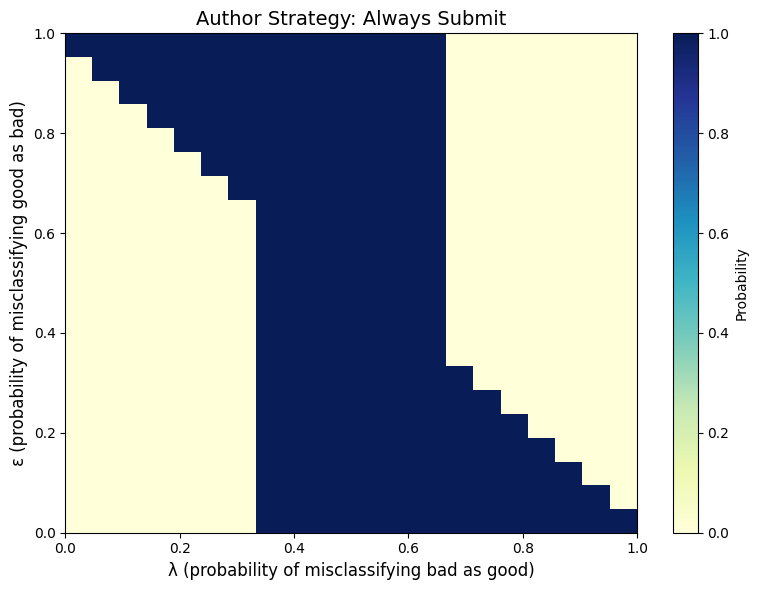

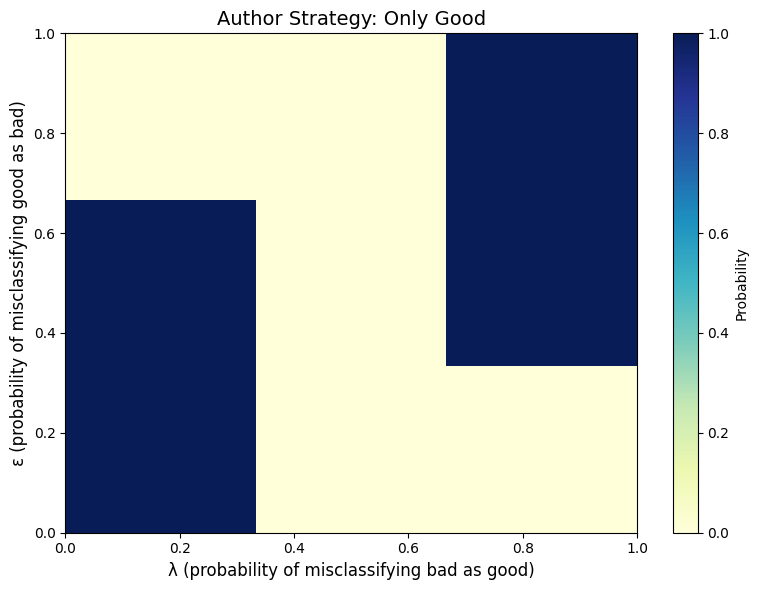

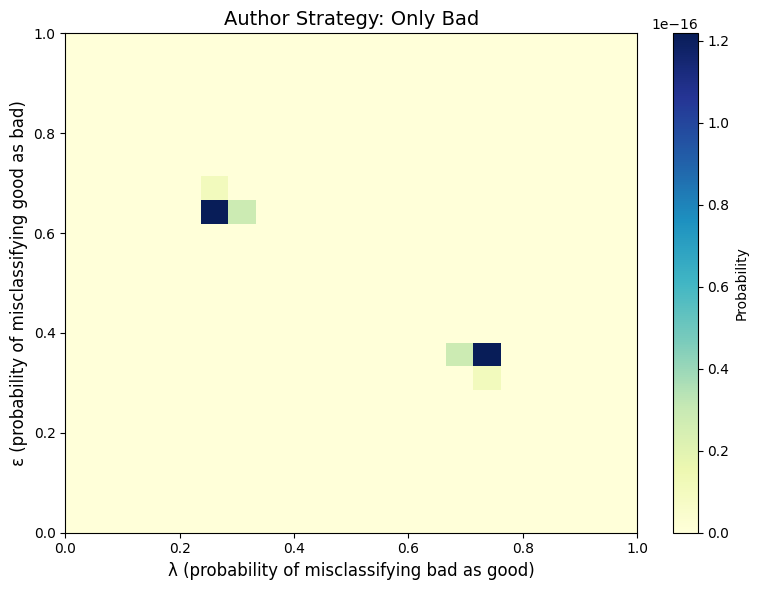

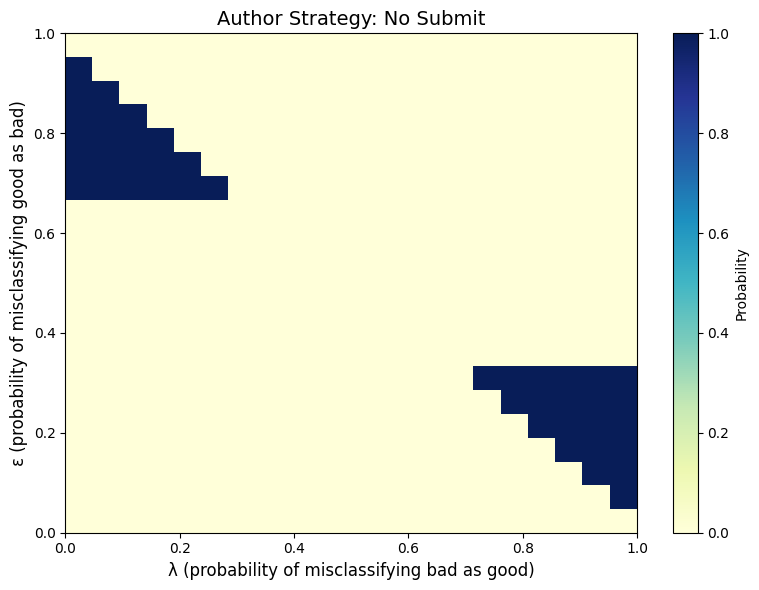

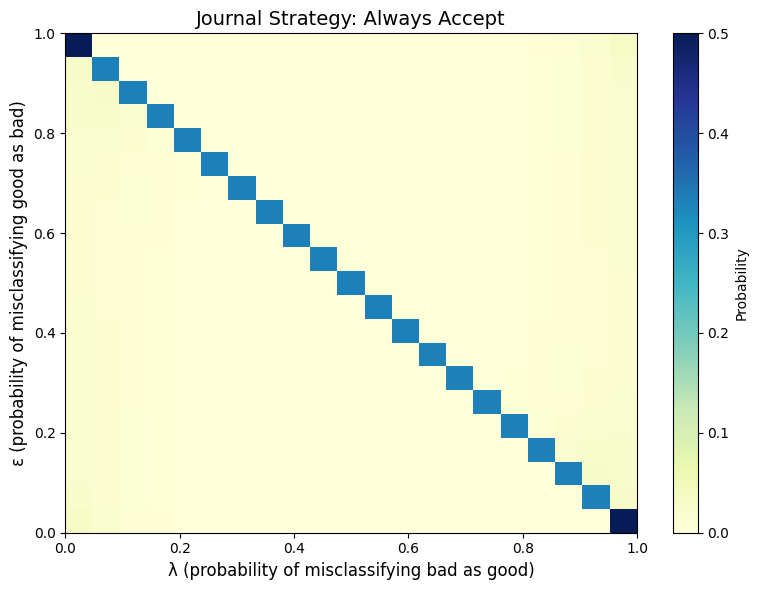

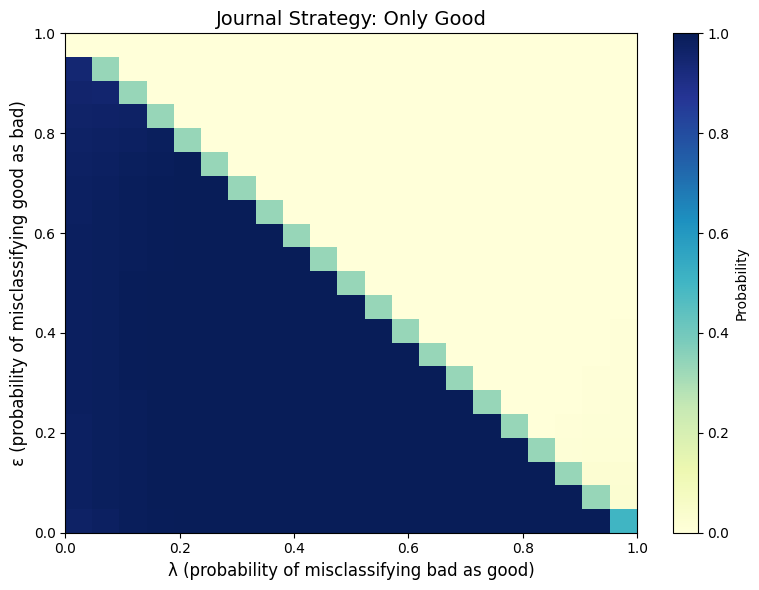

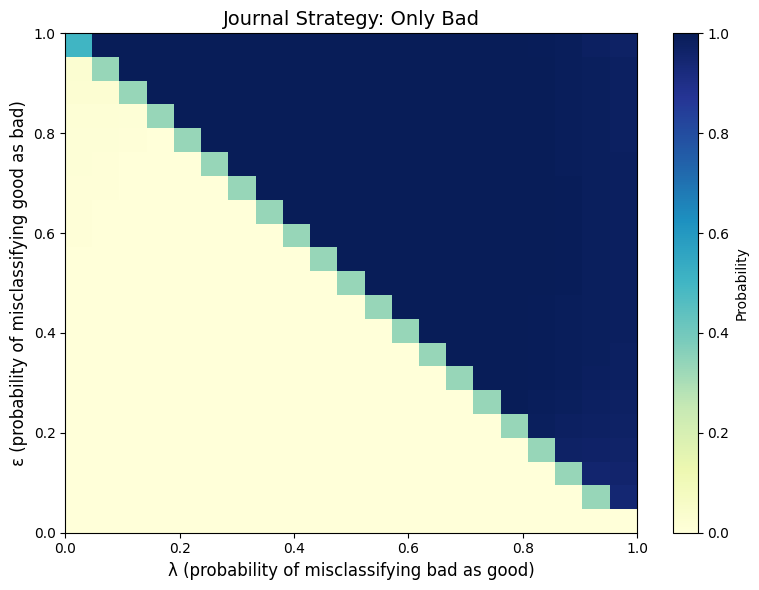

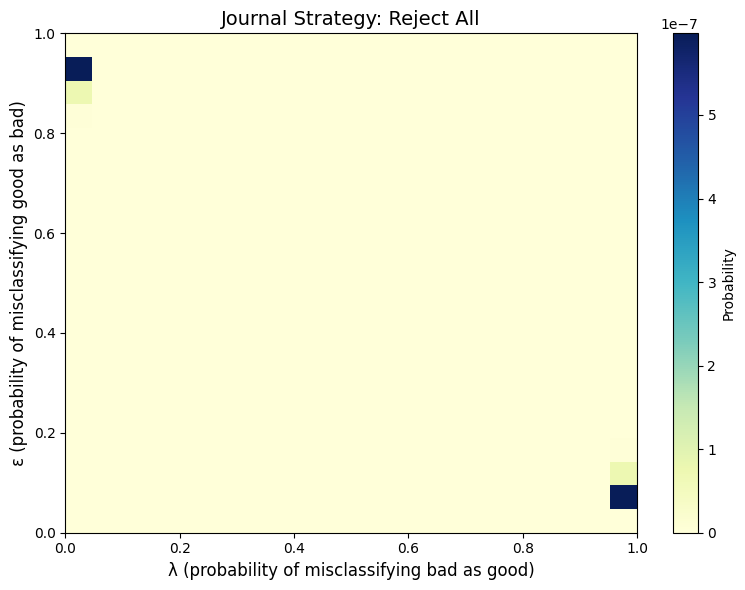

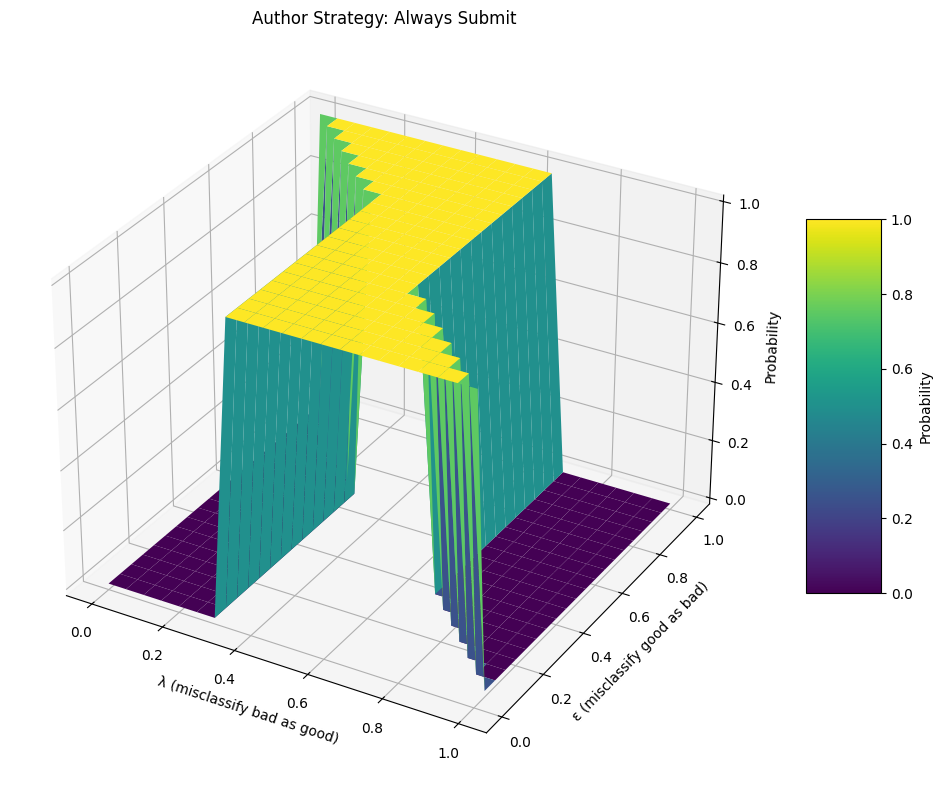

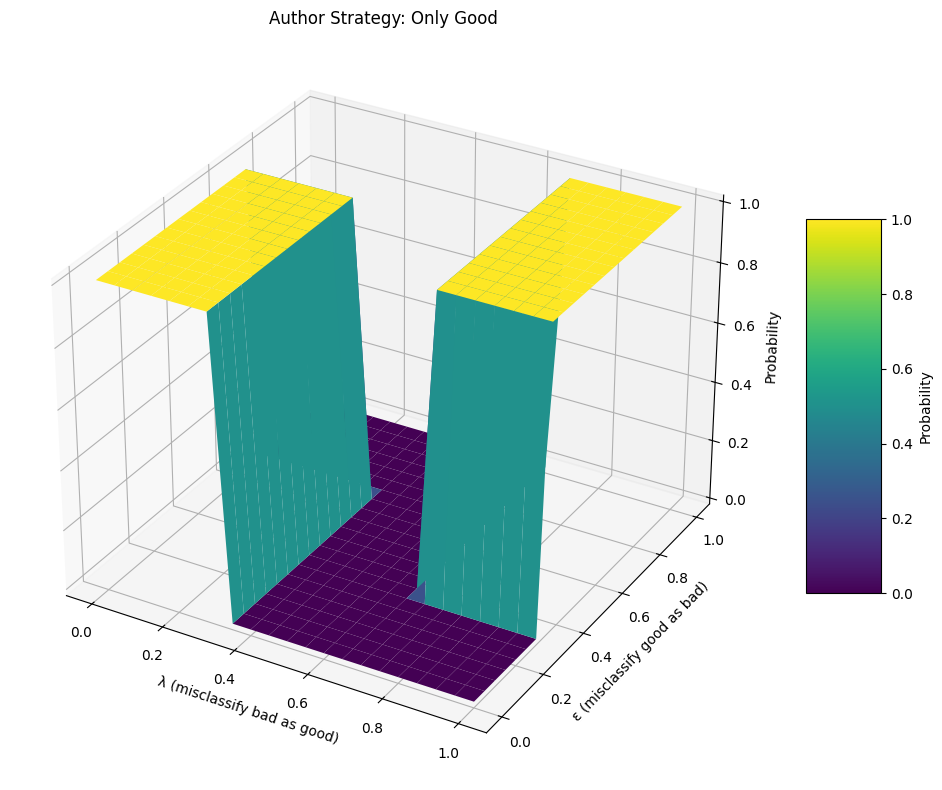

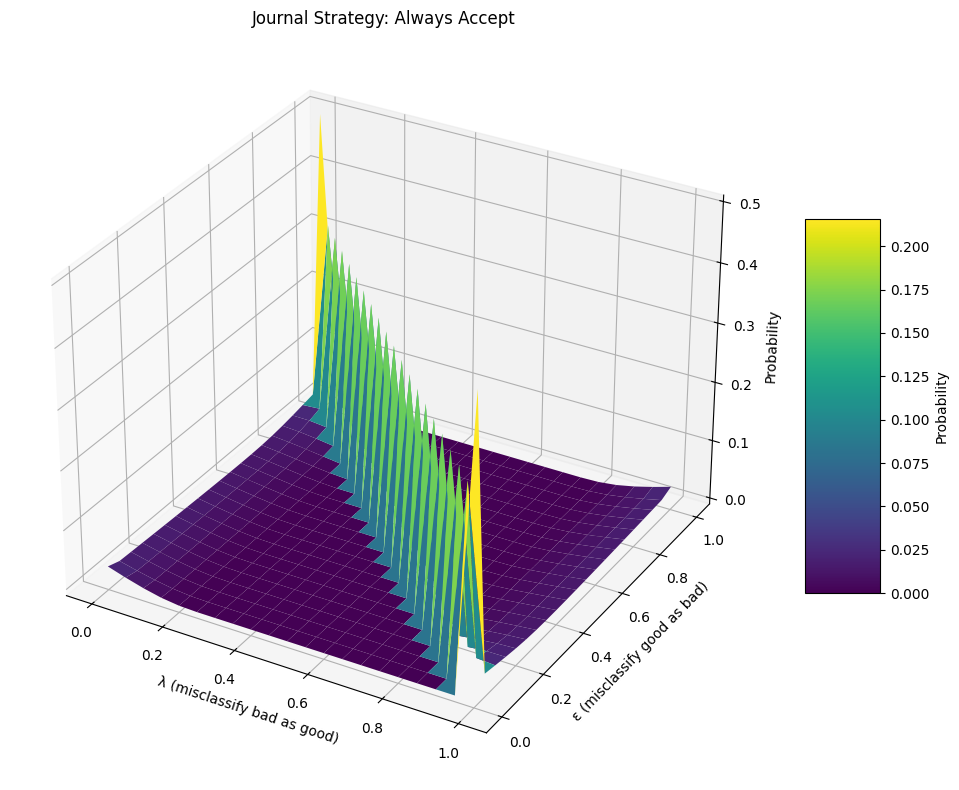

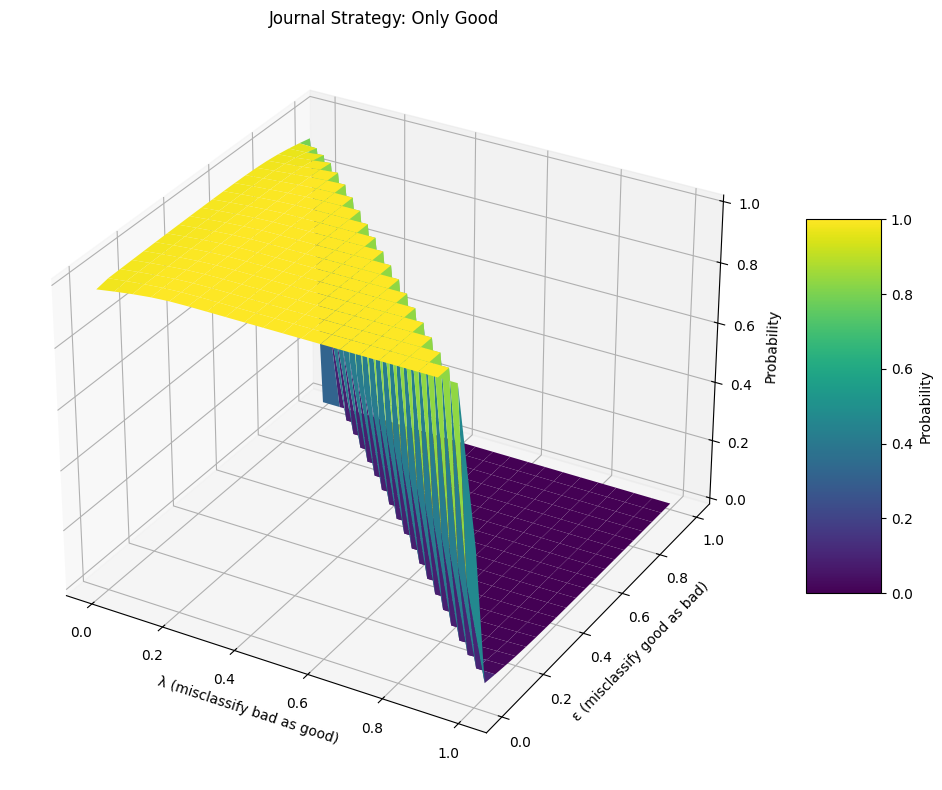

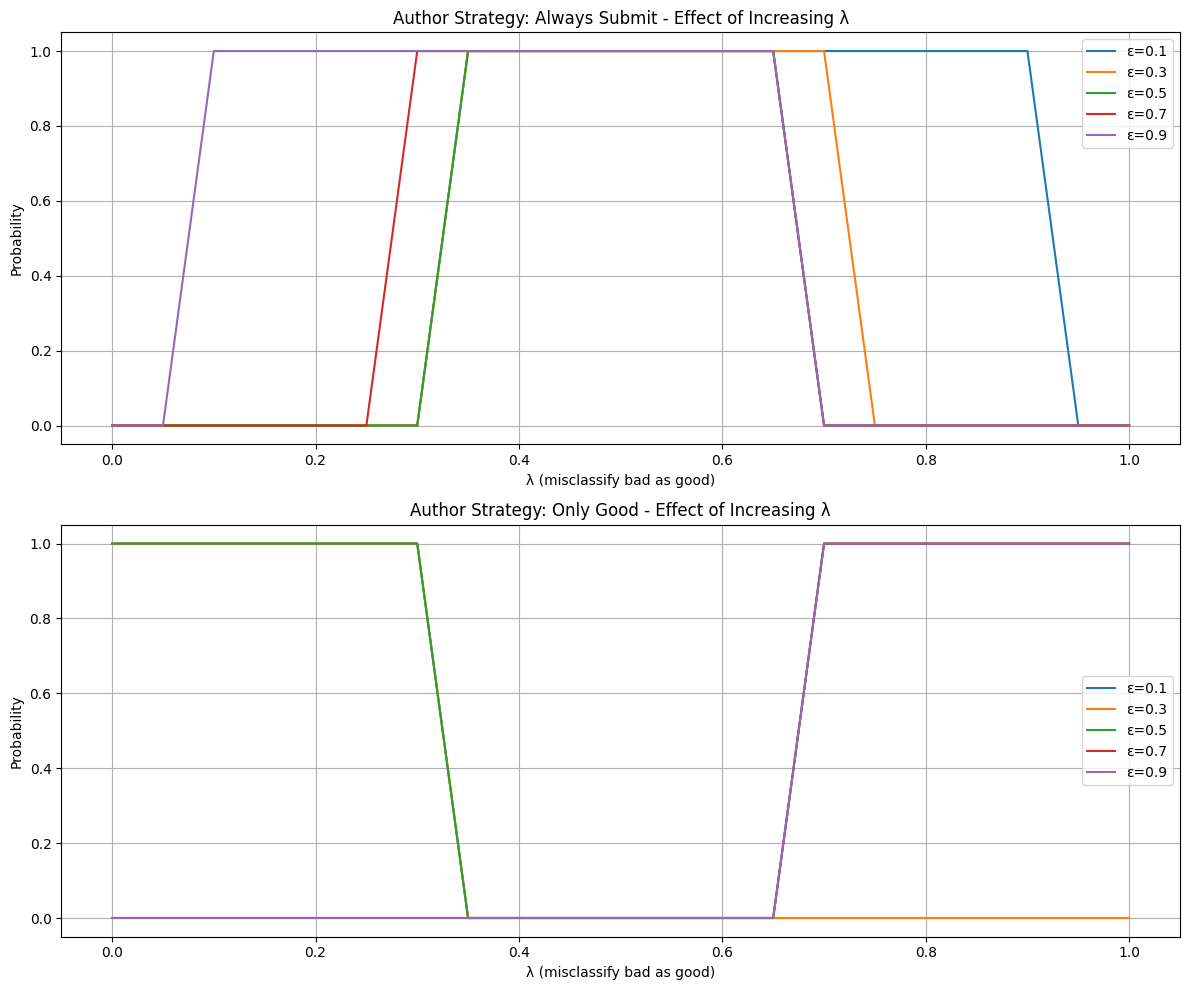

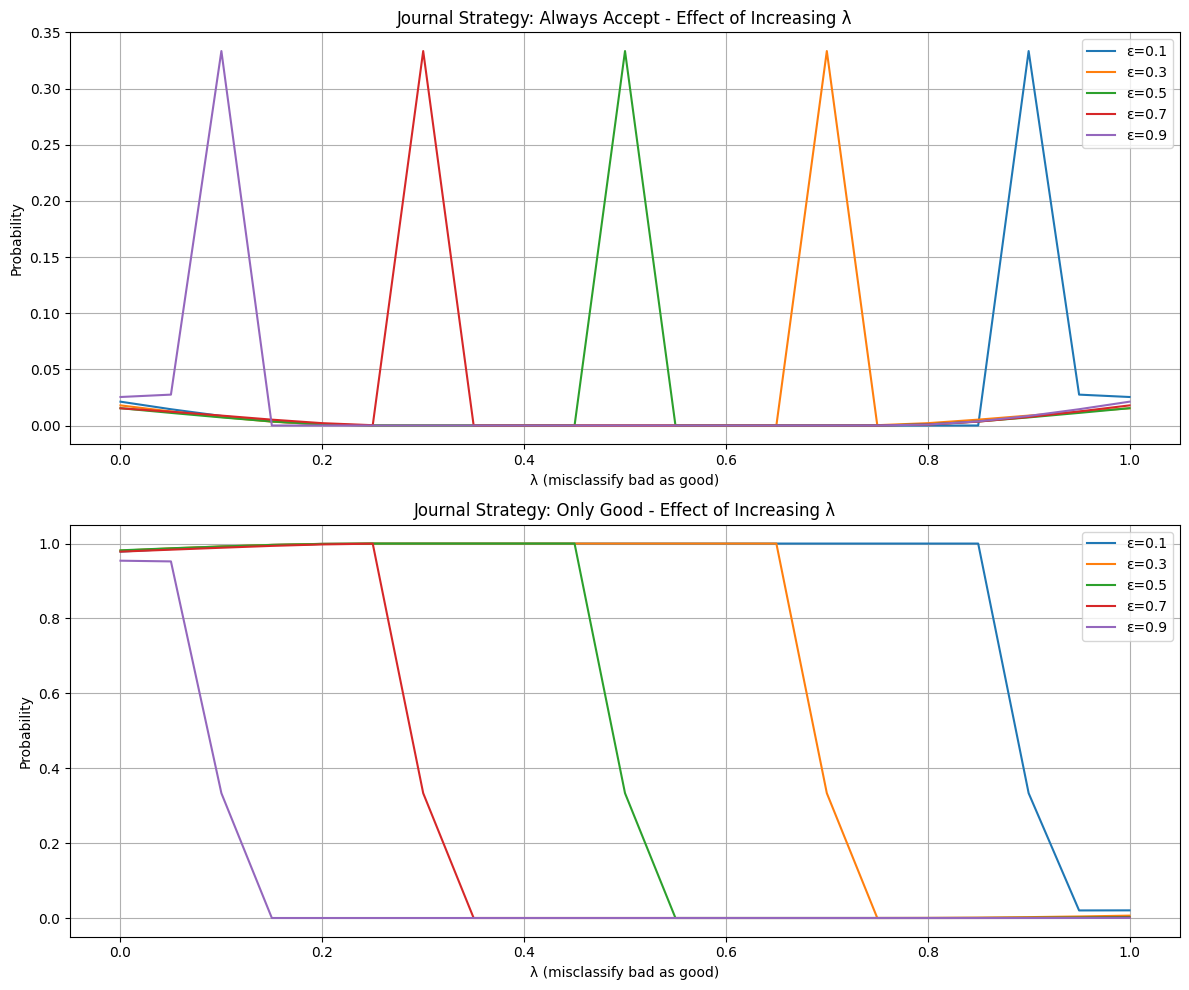

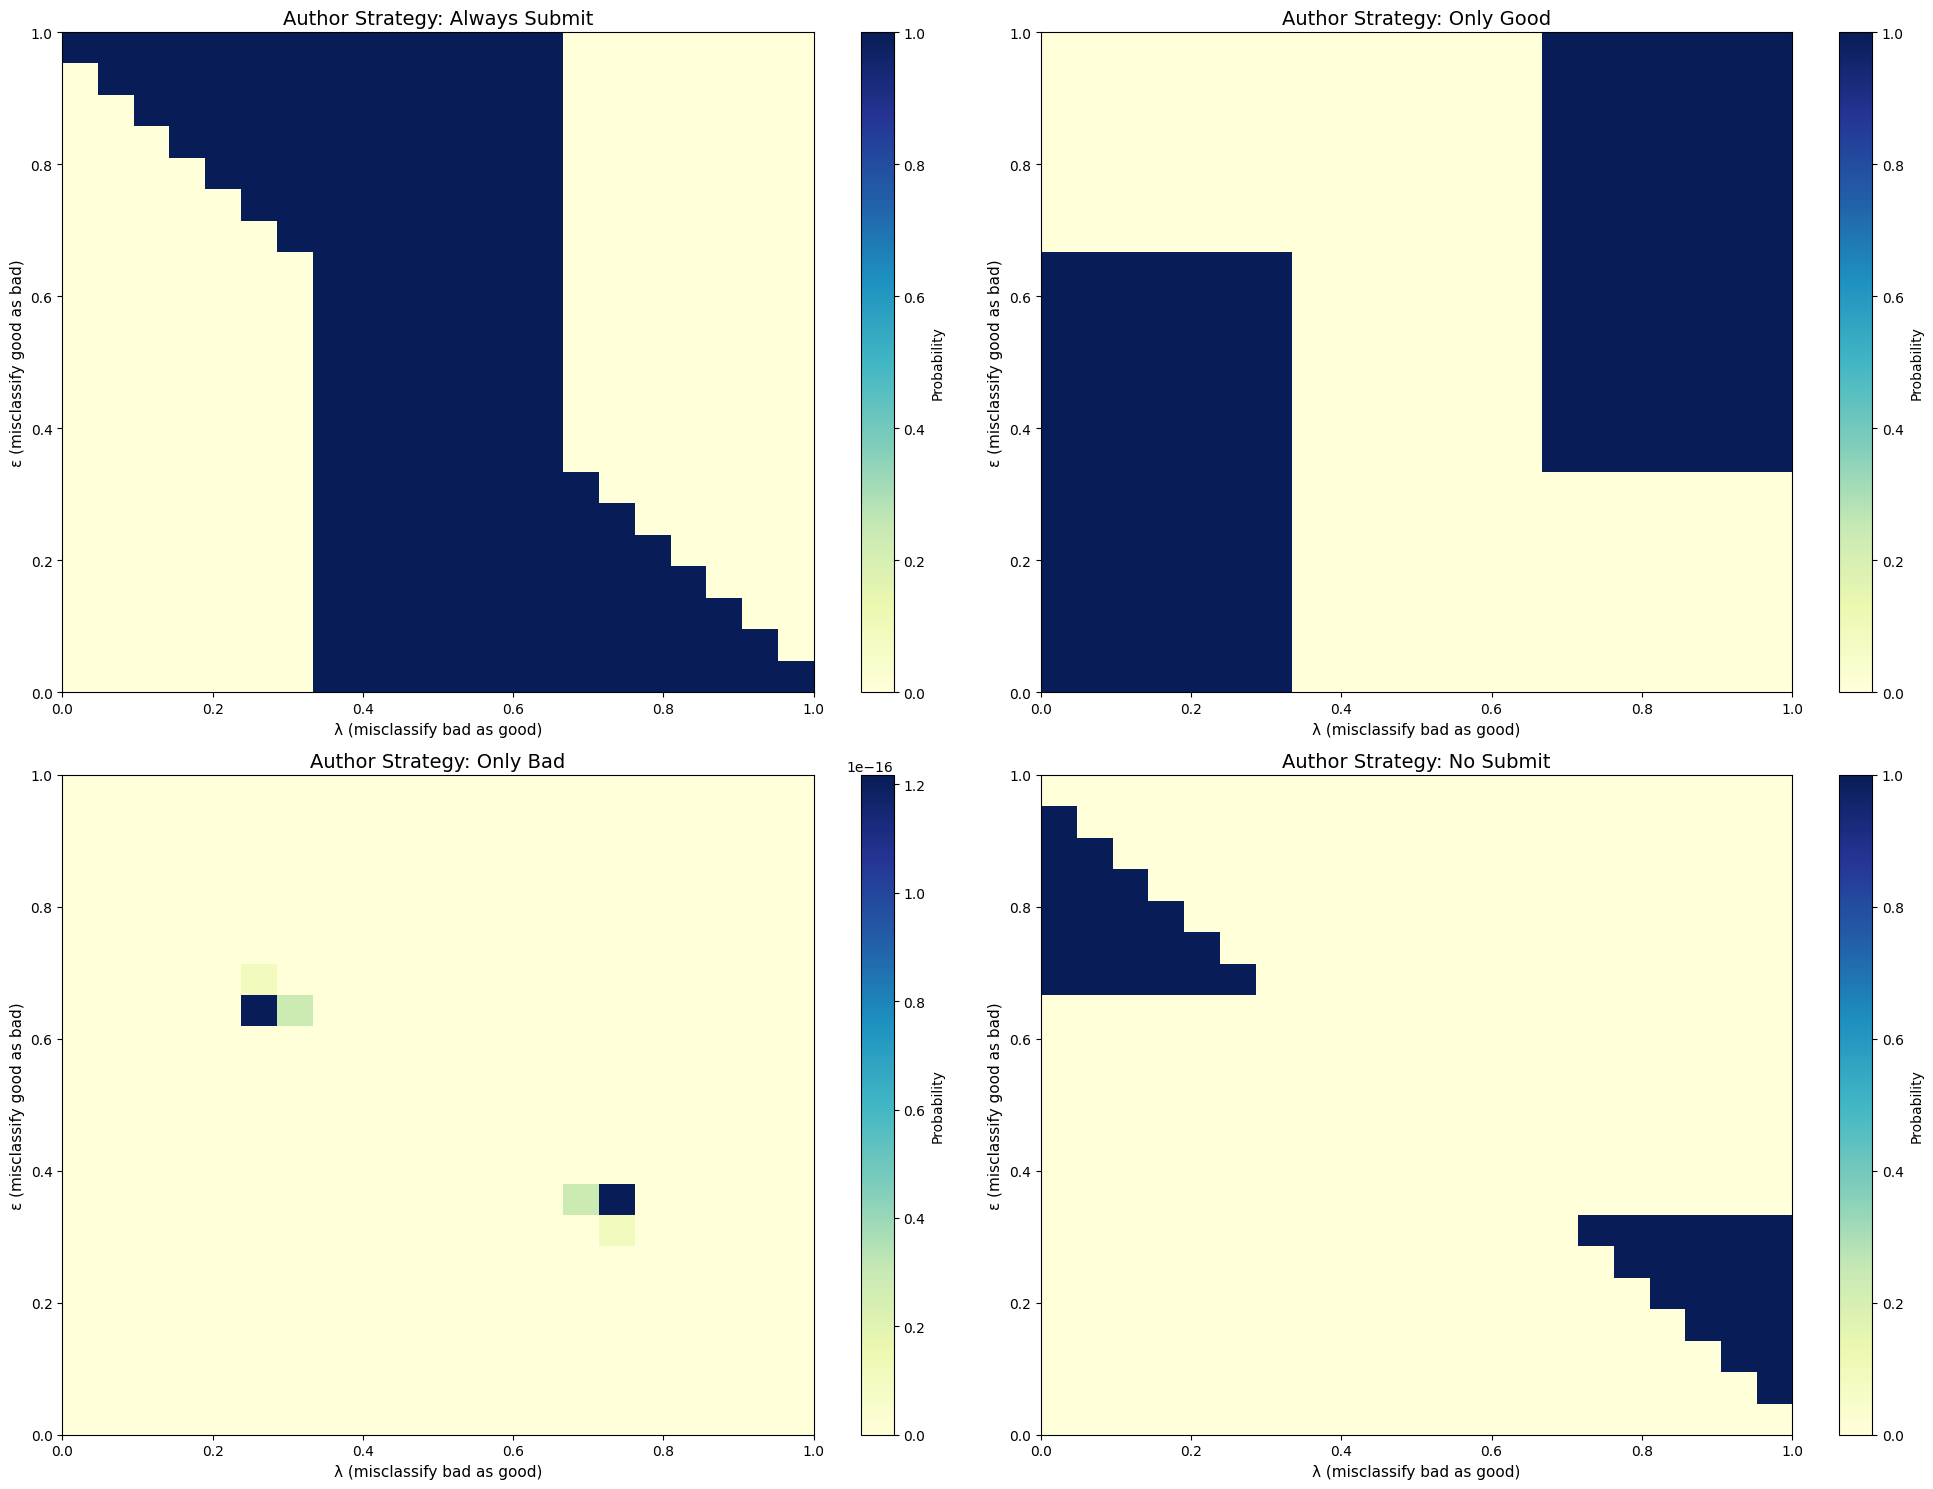

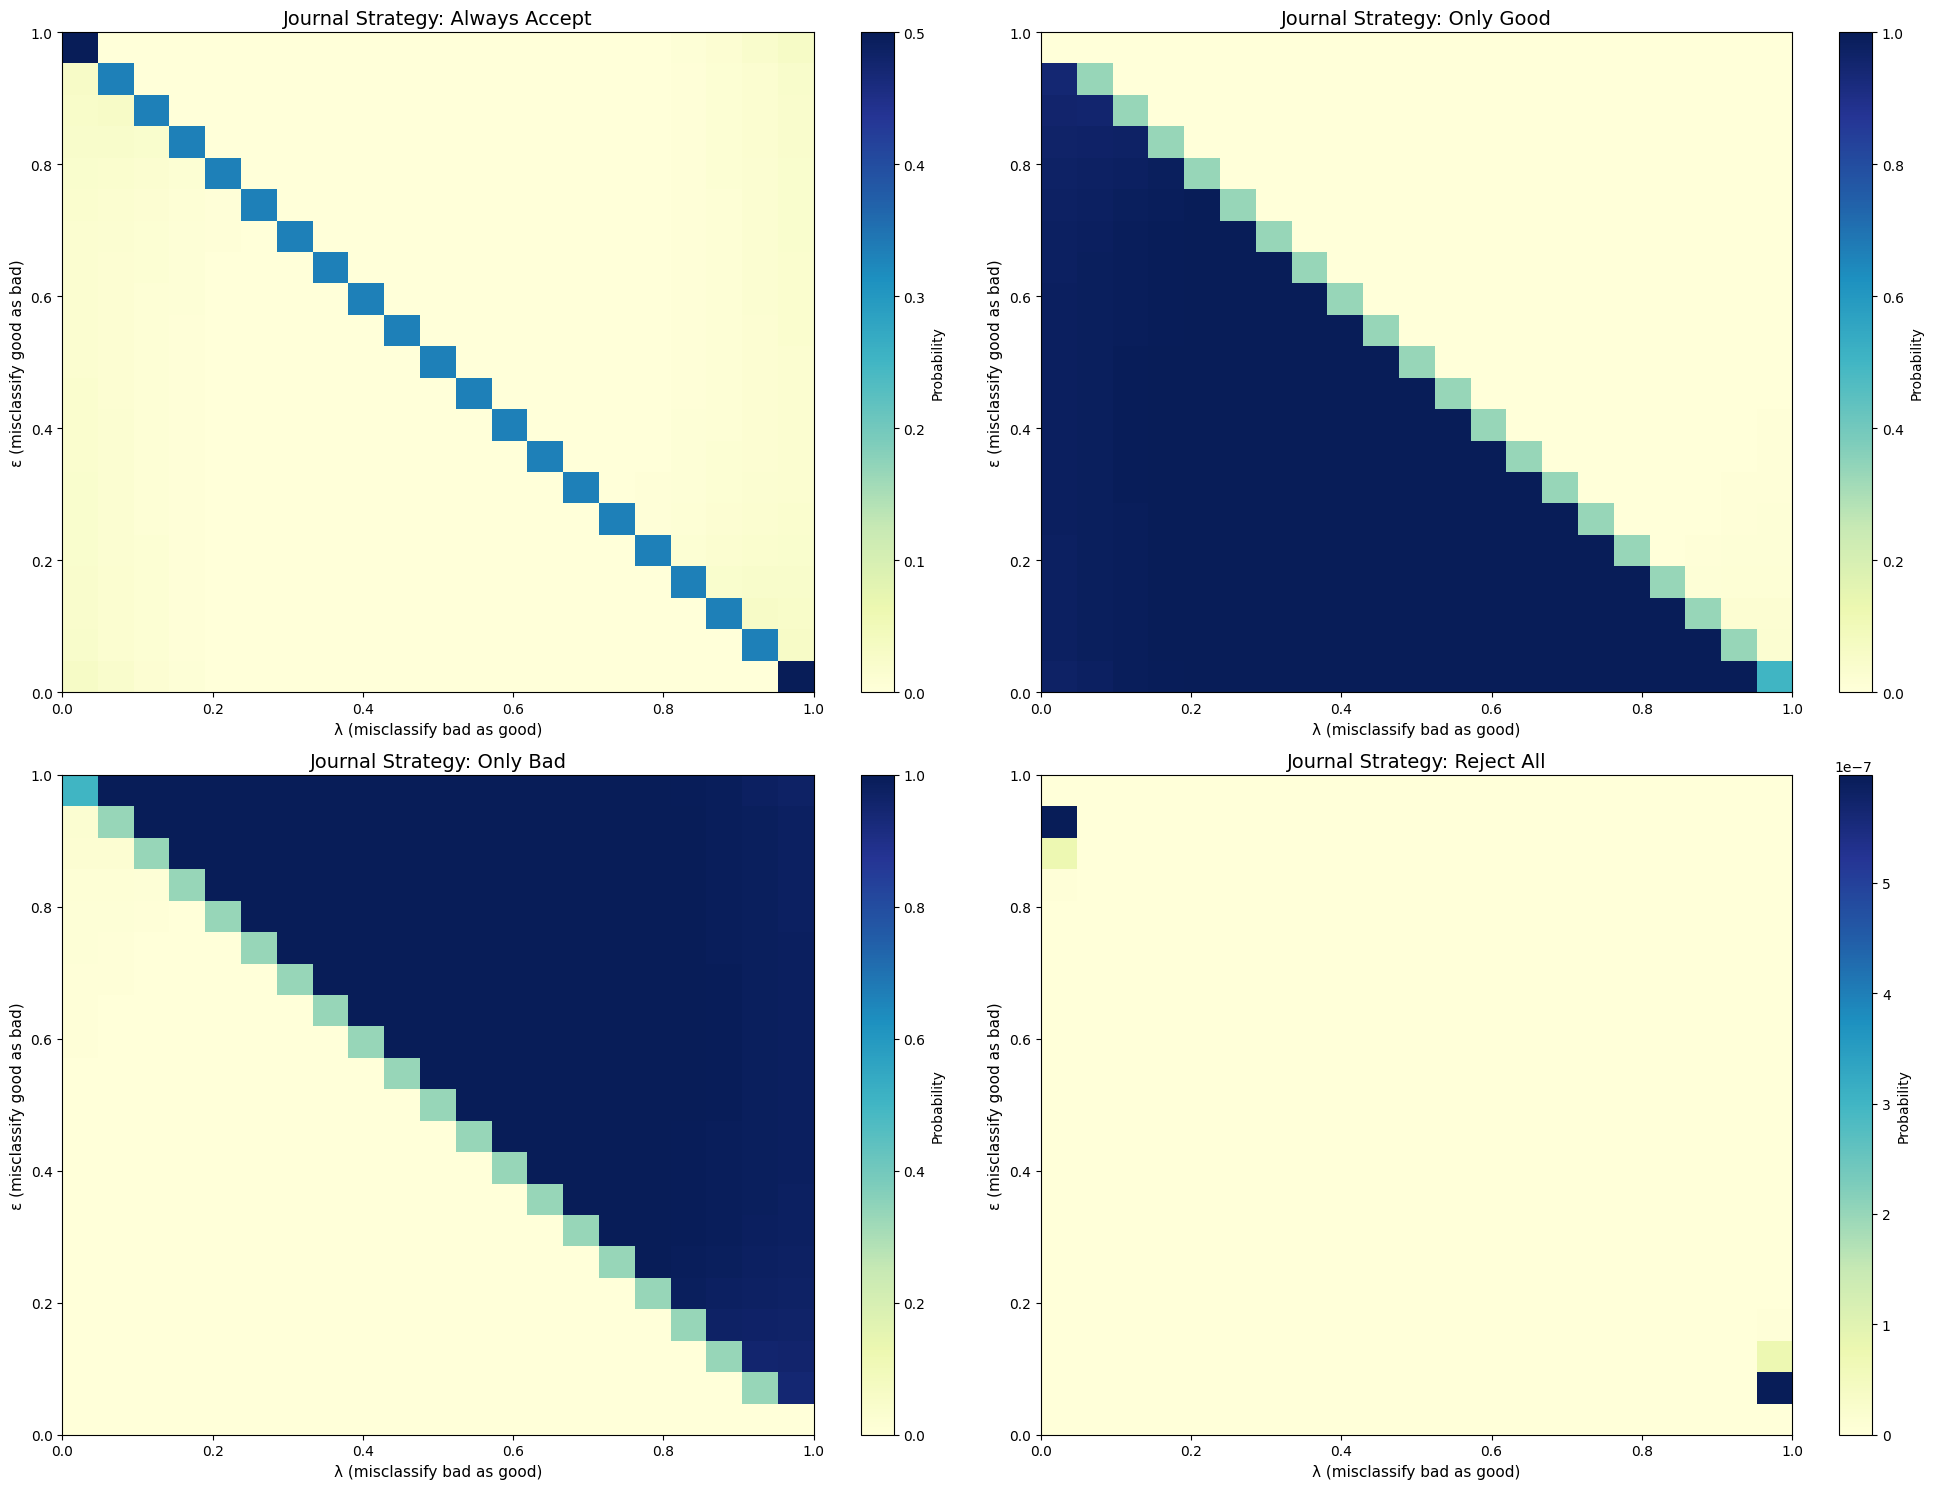

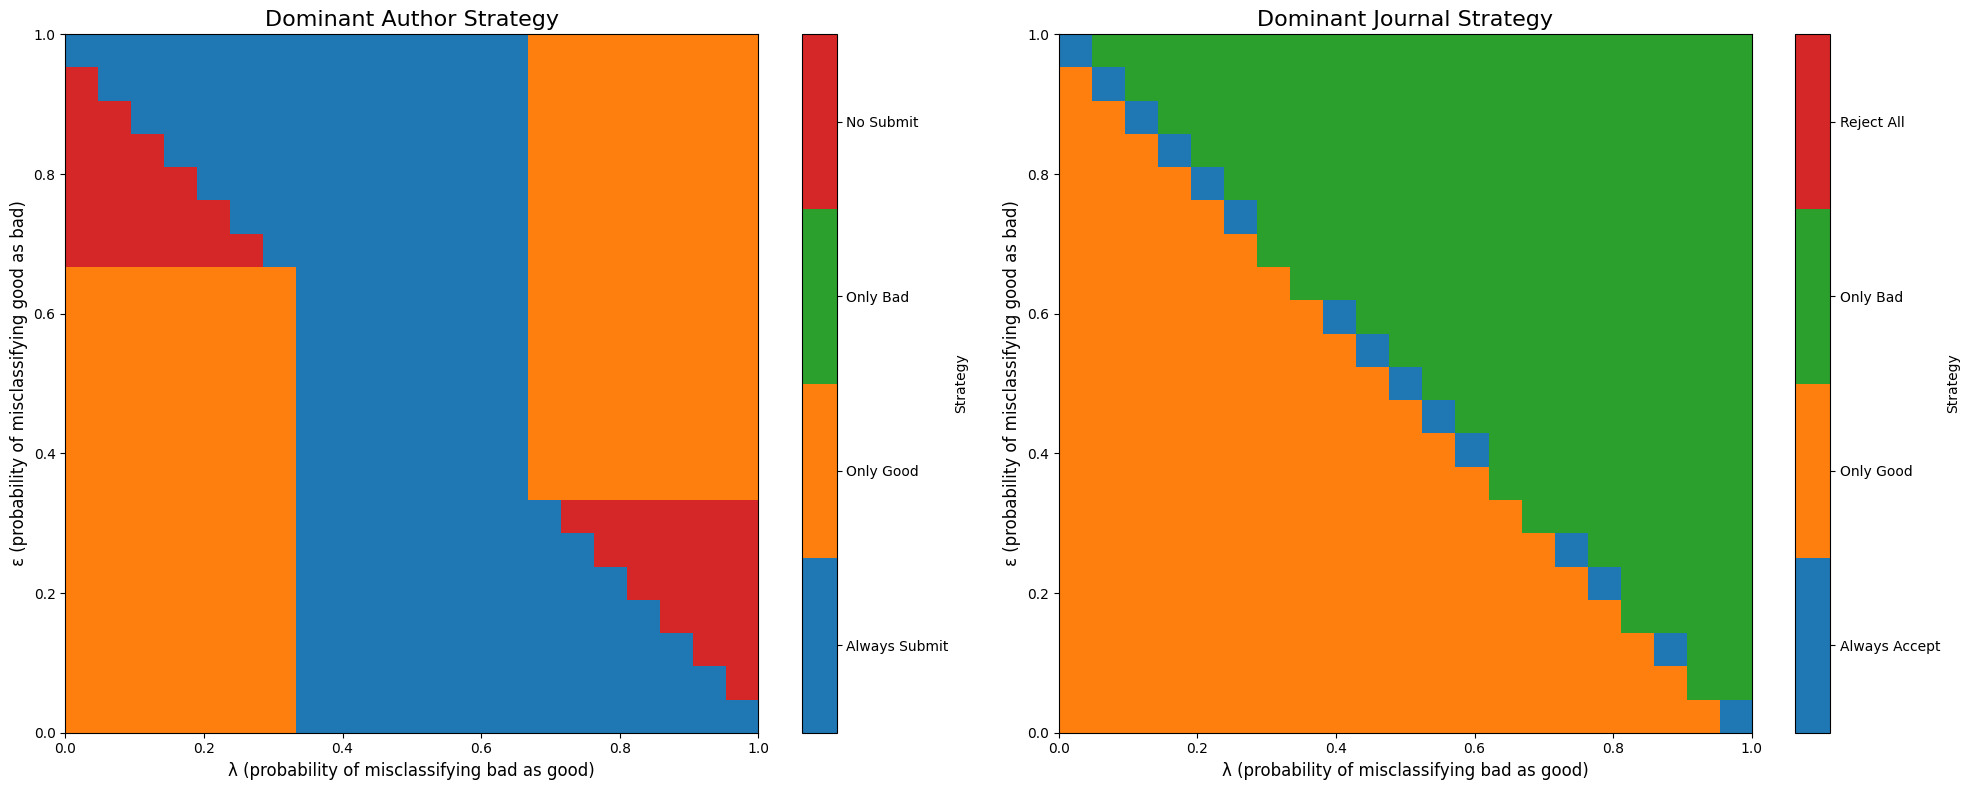

In [ ]:
# Function to create heatmaps for each strategy
def plot_strategy_heatmap(data, strategy_index, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(data[:, :, strategy_index], cmap="YlGnBu", origin='lower', extent=[0, 1, 0, 1], aspect='auto')
    plt.colorbar(label="Probability")
    plt.title(title, fontsize=14)
    plt.xlabel("λ (probability of misclassifying bad as good)", fontsize=12)
    plt.ylabel("ε (probability of misclassifying good as bad)", fontsize=12)
    plt.tight_layout()
    return plt.gcf()

# Generate heatmaps for each strategy
for i, strategy in enumerate(author_names):
    fig = plot_strategy_heatmap(author_results, i, f"Author Strategy: {strategy}")
    fig.savefig(f"author_strategy_{i}_heatmap.png", dpi=300, bbox_inches='tight')

for i, strategy in enumerate(journal_names):
    fig = plot_strategy_heatmap(journal_results, i, f"Journal Strategy: {strategy}")
    fig.savefig(f"journal_strategy_{i}_heatmap.png", dpi=300, bbox_inches='tight')

# Create 3D surface plots to better visualize strategy transitions
def create_3d_surface(data, strategy_index, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(lambda_values, epsilon_values)
    Z = data[:, :, strategy_index]

    surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=True)

    fig.colorbar(surf, shrink=0.5, aspect=5, label="Probability")

    ax.set_xlabel('λ (misclassify bad as good)')
    ax.set_ylabel('ε (misclassify good as bad)')
    ax.set_zlabel('Probability')

    ax.set_title(title)
    plt.tight_layout()
    return fig

# Generate 3D surface plots for the most interesting strategies
create_3d_surface(author_results, 0, "Author Strategy: Always Submit")
plt.savefig("author_strategy_0_3d.png", dpi=300, bbox_inches='tight')

create_3d_surface(author_results, 1, "Author Strategy: Only Good")
plt.savefig("author_strategy_1_3d.png", dpi=300, bbox_inches='tight')

create_3d_surface(journal_results, 0, "Journal Strategy: Always Accept")
plt.savefig("journal_strategy_0_3d.png", dpi=300, bbox_inches='tight')

create_3d_surface(journal_results, 1, "Journal Strategy: Only Good")
plt.savefig("journal_strategy_1_3d.png", dpi=300, bbox_inches='tight')

# Plot cross-sections at specific epsilon values to see transitions
plt.figure(figsize=(12, 10))
epsilon_points = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.subplot(2, 1, 1)
for eps in epsilon_points:
    idx = np.abs(epsilon_values - eps).argmin()
    plt.plot(lambda_values, author_results[idx, :, 0], label=f"ε={eps:.1f}")

plt.xlabel('λ (misclassify bad as good)')
plt.ylabel('Probability')
plt.title('Author Strategy: Always Submit - Effect of Increasing λ')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for eps in epsilon_points:
    idx = np.abs(epsilon_values - eps).argmin()
    plt.plot(lambda_values, author_results[idx, :, 1], label=f"ε={eps:.1f}")

plt.xlabel('λ (misclassify bad as good)')
plt.ylabel('Probability')
plt.title('Author Strategy: Only Good - Effect of Increasing λ')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("author_strategy_transitions.png", dpi=300, bbox_inches='tight')

# Now show how journal strategies transition
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
for eps in epsilon_points:
    idx = np.abs(epsilon_values - eps).argmin()
    plt.plot(lambda_values, journal_results[idx, :, 0], label=f"ε={eps:.1f}")

plt.xlabel('λ (misclassify bad as good)')
plt.ylabel('Probability')
plt.title('Journal Strategy: Always Accept - Effect of Increasing λ')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for eps in epsilon_points:
    idx = np.abs(epsilon_values - eps).argmin()
    plt.plot(lambda_values, journal_results[idx, :, 1], label=f"ε={eps:.1f}")

plt.xlabel('λ (misclassify bad as good)')
plt.ylabel('Probability')
plt.title('Journal Strategy: Only Good - Effect of Increasing λ')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("journal_strategy_transitions.png", dpi=300, bbox_inches='tight')

# Show summary of the findings
print("\nSummary of Findings:")
print("1. Dominant author strategies across error space:")
for i, strategy in enumerate(author_names):
    count = np.sum(dominant_author == i)
    percentage = count / (num_points * num_points) * 100
    print(f"   - {strategy}: {percentage:.1f}% of parameter space")

print("\n2. Dominant journal strategies across error space:")
for i, strategy in enumerate(journal_names):
    count = np.sum(dominant_journal == i)
    percentage = count / (num_points * num_points) * 100
    print(f"   - {strategy}: {percentage:.1f}% of parameter space")

print("\n3. Key transition points:")
# Find boundaries where dominant strategies change
for i in range(num_points-1):
    for j in range(num_points-1):
        if dominant_author[i, j] != dominant_author[i+1, j] or dominant_author[i, j] != dominant_author[i, j+1]:
            print(f"   - Author strategy transition at ε={epsilon_values[i]:.2f}, λ={lambda_values[j]:.2f}")
            break

for i in range(num_points-1):
    for j in range(num_points-1):
        if dominant_journal[i, j] != dominant_journal[i+1, j] or dominant_journal[i, j] != dominant_journal[i, j+1]:
            print(f"   - Journal strategy transition at ε={epsilon_values[i]:.2f}, λ={lambda_values[j]:.2f}")
            break

# Create a single comprehensive figure showing all author strategies
plt.figure(figsize=(20, 15))
for i, strategy in enumerate(author_names):
    plt.subplot(2, 2, i+1)
    plt.imshow(author_results[:, :, i], cmap="YlGnBu", origin='lower', extent=[0, 1, 0, 1], aspect='auto')
    plt.colorbar(label="Probability")
    plt.title(f"Author Strategy: {strategy}", fontsize=14)
    plt.xlabel("λ (misclassify bad as good)", fontsize=11)
    plt.ylabel("ε (misclassify good as bad)", fontsize=11)

plt.tight_layout()
plt.savefig("all_author_strategies.png", dpi=300, bbox_inches='tight')

# Create a single comprehensive figure showing all journal strategies
plt.figure(figsize=(20, 15))
for i, strategy in enumerate(journal_names):
    plt.subplot(2, 2, i+1)
    plt.imshow(journal_results[:, :, i], cmap="YlGnBu", origin='lower', extent=[0, 1, 0, 1], aspect='auto')
    plt.colorbar(label="Probability")
    plt.title(f"Journal Strategy: {strategy}", fontsize=14)
    plt.xlabel("λ (misclassify bad as good)", fontsize=11)
    plt.ylabel("ε (misclassify good as bad)", fontsize=11)

plt.tight_layout()
plt.savefig("all_journal_strategies.png", dpi=300, bbox_inches='tight')

# Return the main visualization for display in the notebook
plt.figure(figsize=(20, 8))

# Plot dominant author strategies
plt.subplot(1, 2, 1)
plt.imshow(dominant_author, cmap=strategy_cmap, origin='lower', extent=[0, 1, 0, 1], aspect='auto')
cb = plt.colorbar(ticks=[0, 1, 2, 3], label="Strategy")
plt.clim(-0.5, 3.5)
plt.title("Dominant Author Strategy", fontsize=16)
plt.xlabel("λ (probability of misclassifying bad as good)", fontsize=12)
plt.ylabel("ε (probability of misclassifying good as bad)", fontsize=12)

# Add strategy labels to the colorbar
cb.set_ticklabels(author_names)

# Plot dominant journal strategies
plt.subplot(1, 2, 2)
plt.imshow(dominant_journal, cmap=strategy_cmap, origin='lower', extent=[0, 1, 0, 1], aspect='auto')
cb = plt.colorbar(ticks=[0, 1, 2, 3], label="Strategy")
plt.clim(-0.5, 3.5)
plt.title("Dominant Journal Strategy", fontsize=16)
plt.xlabel("λ (probability of misclassifying bad as good)", fontsize=12)
plt.ylabel("ε (probability of misclassifying good as bad)", fontsize=12)

# Add strategy labels to the colorbar
cb.set_ticklabels(journal_names)

plt.tight_layout()